# Left-wing vs Right-wing Media on US President Donald Trump

The idea of this project is to gauge media content which focuses on Donald Trump. We are using content from CNN (Left-wing) and Fox News (Right-wing) and construct a data science pipeline, to gauge how media discusses the issues pertaining to the executive.

The Data Science pipeline elements we are focusing on:

1. Data Acquisition
2. Data Wrangling
3. Data Exploration and Data Analysis
4. Data Science Predictive Model
5. Policy Analysis

## 1. Data Acquisition

There are no readily available datasets which give right-wing and left-wing media data. So, we have to extract it from sources on the web. Now, from popular sources, it is widely accepted that CNN is left-leaning and Fox News is right-leaning. Therefore, we will use their content as proxies for left-leaning and right-leaning discussion on Donald Trump and the incumbent government.

### 1.1 Data from CNN and Fox

Both CNN and Fox News have a search feature, where we will search for Donald Trump, and extract URLs of the news article from there. The idea is to get around 3000-4000 articles per set. So, we will extract 3000-4000 URLs from the search options and then extract title and text from each article's URL. This is done using Selenium and BeautifulSoup. Selenium has been used to open the search browser and extract the URLs. BeautifulSoup can extract the text from each news article URL.

In [1]:
import requests, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# from bs4 import BeautifulSoup
import time
# from selenium import webdriver

## 2.1 Data Wrangling and Data Cleaning

In [2]:
import string
from collections import Counter
# from wordcloud import WordCloud
import re
import spacy
import spacy
nlp = spacy.load('en')
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)
import nltk
# nltk.download('punkt')



import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from tqdm import tqdm
import collections
import random
punctuations = string.punctuation

In [3]:
fox_trump = pd.read_pickle("Fox Trump Articles.pkl")
cnn_trump = pd.read_pickle("CNN Trump Articles.pkl")

In [4]:
def process(text):
    table = {ord(char): " " for char in string.punctuation}
    return [t for t in nltk.word_tokenize(str(text).lower().replace("""\\""","").replace("`s", "").replace("'s", "").replace("`", "'").replace("'","").translate(table))]

# stop_words = set(stopwords.words('english'))
stopwords = list(STOP_WORDS)

fox_trump["title_processed"] = fox_trump["title"].apply(lambda x: [w for w in process(x) if w not in stopwords])
fox_trump["text_processed"] = fox_trump["text"].apply(lambda x: [w for w in process(x) if w not in stopwords])

cnn_trump["title_processed"] = cnn_trump["title"].apply(lambda x: [w for w in process(x) if w not in stopwords])
cnn_trump["text_processed"] = cnn_trump["text"].apply(lambda x: [w for w in process(x) if w not in stopwords])

## Exploratory Data Analysis

Exploratory data analysis in NLP is slightly different than other data analysis fields. Before we jumped into classifying the data, we wanted to get a feel for how the features we will be using differ between the real news and fake news. Usually, it is hard to visualize text data. However, when working on this specific application, there are certain features of news writing we can take advantage of to do visualizations that are not possible in other forms of text data.


### Word Cloud

The first element of exploratory analysis and visualization will be to understand the general density distribution of words, both in real news and fake news. This will help us understand which of the words are more likely to come up in real news and which ones come up more in fake news. For this, we will be using the Word Cloud package, which was tailor-made for this purpose.

In [5]:
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
import matplotlib.pyplot as plt

#### Text Features

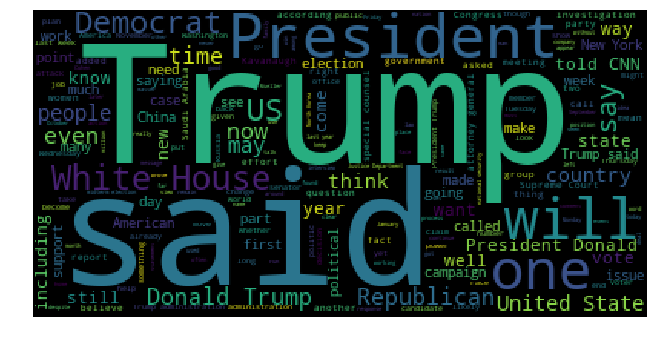

In [6]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(" ".join(cnn_trump["text"]))
plt.imshow(wordcloud)
plt.gcf().set_size_inches(11, 8)#, interpolation='bilinear')
plt.axis("off");

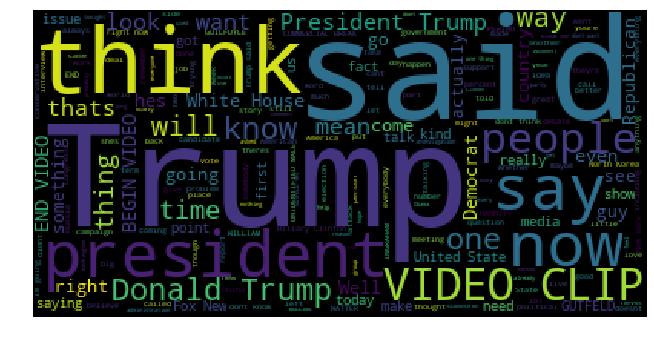

In [7]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(" ".join(fox_trump["text"]))
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.gcf().set_size_inches(11, 8)
plt.axis("off");

An interesting comparison can be made between the two word clouds of CNN and Fox News text.

CNN News - The term Democrat appears more than Republican, New York is a prominent topic of discussion, other obvious terms include supreme court, government. Also, as news articles are based on witness acounts, said is a more important term for CNN.

Fox News - The most interesting term here is 'think'. It appears a disproportionate number of times. Interestingly, they have a sizeable observation for 'Democrat', but 'Republican' is not there at all.

### Title Features

(-0.5, 399.5, 199.5, -0.5)

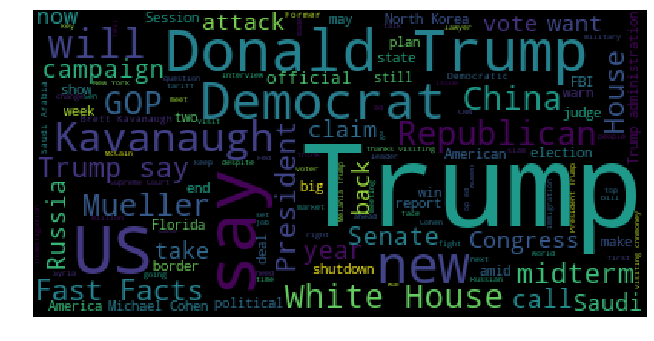

In [8]:
wordcloud = WordCloud(stopwords=STOPWORDS, normalize_plurals= True).generate(" ".join(cnn_trump["title"]))
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.gcf().set_size_inches(11,8)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

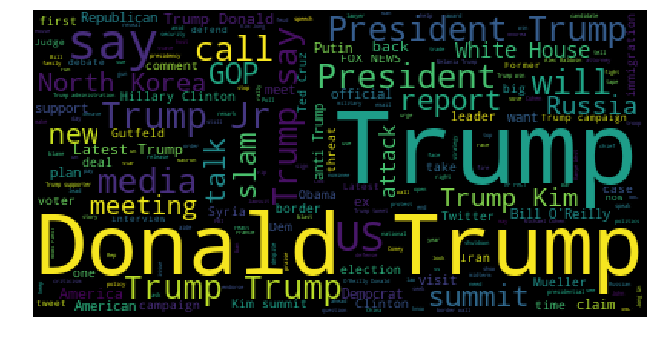

In [9]:
wordcloud = WordCloud(stopwords=STOPWORDS, normalize_plurals= True).generate(" ".join(fox_trump["title"]))
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.gcf().set_size_inches(11,8)
plt.axis("off")

CNN News - Some of the interesting talking points here are China, Kavanaugh. One of the most important title features is Mueller, who is leading a special investigation on President Trump.

Fox News - The most interesting terms here are Kim, referring to the North Korean dictator; Clinton; media; attack.

### N-grams Analysis

Then, another important element in language analysis is visualizing n-grams. For this, we have created a function which can take the text and create n-grams for various n. This helps us in realizing which words or word combination are considered important by different media houses. There might be some interesting word combinations which may help understand their importance. 

In [10]:
def generate_ngrams_string(s, n):
    # Convert to lowercases
    s = s.lower()
    s = s.replace("'", "_")
    s = s.replace("`", "_")
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [11]:
def ngrams_series(s, n):
    ngrams = Counter()
    for i in range(len(s)):
        ngrams.update(generate_ngrams_string(s[i], n))
        
    return ngrams

In [12]:
fox_trump_words = ngrams_series(fox_trump["text"], 1)
cnn_trump_words = ngrams_series(cnn_trump["text"], 1)
fox_trump_bigrams = ngrams_series(fox_trump["text"], 2)
cnn_trump_bigrams = ngrams_series(cnn_trump["text"], 2)
fox_trump_trigrams = ngrams_series(fox_trump["text"], 3)
cnn_trump_trigrams = ngrams_series(cnn_trump["text"], 3)
fox_trump_quadgrams = ngrams_series(fox_trump["text"], 4)
cnn_trump_quadgrams = ngrams_series(cnn_trump["text"], 4)
fox_trump_pentagrams = ngrams_series(fox_trump["text"], 5)
cnn_trump_pentagrams = ngrams_series(cnn_trump["text"], 5)

In [14]:
cnn_trump_quadgrams.most_common(10)

[('said in a statement', 561),
 ('of the united states', 501),
 ('in the united states', 424),
 ('the new york times', 379),
 ('special counsel robert mueller', 352),
 ('at the white house', 329),
 ('in the white house', 326),
 ('the end of the', 303),
 ('president of the united', 295),
 ('president donald trump s', 291)]

In [15]:
cnn_trump_trigrams.most_common(5)

[('the white house', 2632),
 ('the united states', 2343),
 ('president donald trump', 1992),
 ('the president s', 1553),
 ('one of the', 1188)]

In [16]:
cnn_trump_quadgrams.most_common(10)

[('said in a statement', 561),
 ('of the united states', 501),
 ('in the united states', 424),
 ('the new york times', 379),
 ('special counsel robert mueller', 352),
 ('at the white house', 329),
 ('in the white house', 326),
 ('the end of the', 303),
 ('president of the united', 295),
 ('president donald trump s', 291)]

In [17]:
fox_trump_quadgrams.most_common(10)

[('of the united states', 726),
 ('a lot of people', 568),
 ('president of the united', 498),
 ('is going to be', 477),
 ('the new york times', 449),
 ('what do you think', 382),
 ('end video clip hannity', 326),
 ('going to be a', 322),
 ('its going to be', 320),
 ('we are going to', 319)]

So, bigrams and trigrams include basic words combinations like "of the", "one of the", "the white house" etc. We witness some interesting combinations when it comes to quadgrams. First of all, both CNN and Fox refer to the New York Times a lot. Fox News also likes to refer to specific TV show hosts like Sean Hannity, as compared to CNN, who don't mention them as often.

In [18]:
word_count = Counter()

for i in range(len(fox_trump)):
    word_count.update(fox_trump.loc[i]["text"])
    word_count.update(fox_trump.loc[i]["title"])

for i in range(len(cnn_trump)):
    word_count.update(cnn_trump.loc[i]["text"])
    word_count.update(cnn_trump.loc[i]["title"])

rare_words = [word for word, count in word_count.items() if count == 1]

## Advanced Data Analysis

### Tagging and Topic Modeling

Now, we would like to move to some advanced data analysis and modelling. For this, we would like to us packages like Spacy to help us. Using Spacy, let's see if we can do topic modeling to understand what are the general topics of discussion in the news surrounding US President Donald Trump. 

Below can be seen how a sample text has been tagged:

In [19]:
nlp = spacy.load('en')
doc = nlp(fox_trump["text"][3])
spacy.displacy.render(doc, style='ent', jupyter=True)

In [20]:

# review = str(" ".join([i.lemma_ for i in doc]))

In [21]:
# doc = nlp(review)
# spacy.displacy.render(doc, style='ent',jupyter=True)

In [22]:
for i in doc:
    print(i,"=>",i.pos_)

President => PROPN
keeps => VERB
up => PART
trade => NOUN
policy => NOUN
pressure => NOUN
as => ADP
many => ADJ
Americans => PROPN
feel => VERB
tariff => NOUN
pressures => NOUN
; => PUNCT
Kevin => PROPN
Corke => PROPN
reports => VERB
from => ADP
the => DET
White => PROPN
House => PROPN
. => PUNCT
Mid => PROPN
Continent => PROPN
and => CCONJ
its => ADJ
employees => NOUN
are => VERB
early => ADJ
victims => NOUN
in => ADP
Trumps => PROPN
trade => NOUN
war => NOUN
. => PUNCT
There => ADV
will => VERB
be => VERB
many => ADJ
more => ADJ
if => ADP
the => DET
president => NOUN
continues => VERB
to => PART
raise => VERB
import => NOUN
costs => NOUN
and => CCONJ
anger => VERB
our => ADJ
trading => NOUN
partners => NOUN
. => PUNCT
Since => ADP
the => DET
start => NOUN
of => ADP
the => DET
year => NOUN
, => PUNCT
President => PROPN
Trump => PROPN
has => VERB
announced => VERB
a => DET
string => NOUN
of => ADP
new => ADJ
tariffs => NOUN
- => PUNCT
which => ADJ
, => PUNCT
let => VERB
’s => PRON
be =

The package is smart enough to tag proper nouns, nouns, verbs, locations, adjectives, which makes language modeling pretty easy. Now, we begin the topic modeling. We will club all of the text in the media together and generate analysis to visualize and discuss the topics.

We are doing this topic modeling by two different methods. One is by non-negative matrix factorization modeling, and the other is latent semantic indexing using trucated SVD.

In [23]:
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [24]:
tqdm.pandas()
fox_trump["processed_text"] = fox_trump["text"].apply(spacy_tokenizer)
cnn_trump["processed_text"] = cnn_trump["text"].apply(spacy_tokenizer)

In [25]:
all_text = pd.Series(cnn_trump["processed_text"].append(fox_trump["processed_text"]).reset_index()["processed_text"])
# all_text

In [26]:
all_text_unprocessed = pd.Series(cnn_trump["text"].append(fox_trump["text"]).reset_index()["text"])
# all_text_unprocessed

In [37]:
common_list = [] #+ ["president", "trump", "donald", "think", "no", "like", "tell", "come", "know", "thing", "want", "look", "yes", "yeah", "year"]
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=STOP_WORDS, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(all_text)

NUM_TOPICS = 10
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [38]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 



# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [39]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
print(selected_topics(lda, vectorizer))

LDA Model:
Topic 0:
[('republican', 7343.00962997839), ('vote', 4752.706012832435), ('election', 4679.804651664804), ('state', 4528.769983149625), ('win', 4306.329593009644), ('democrats', 4164.336326790488), ('candidate', 4029.155371396423), ('campaign', 3718.7800896529757), ('party', 3703.3051934461137), ('voter', 3586.4068299105043)]
Topic 1:
[('people', 3458.503750538623), ('border', 2746.8247190433544), ('country', 2603.418207284939), ('american', 1989.4661066234353), ('president', 1879.7357145837886), ('immigration', 1750.0707351611784), ('family', 1449.0023570844248), ('child', 1371.5909046494535), ('united', 1311.407191716309), ('law', 1253.1562934925907)]
Topic 2:
[('year', 1400.820113524005), ('health', 1172.5477436671963), ('government', 1141.159349829648), ('million', 1113.8015498065924), ('federal', 1089.3198963082189), ('tax', 1047.9883153173282), ('new', 1020.4537607365684), ('law', 1015.3152820499231), ('fund', 971.7310025656701), ('state', 965.7181058331084)]
Topic 3:


The results are highly interesting. Let us go over some of the potential topics of discussion from the LDA model here:

1. The first one is on the special investigation led by Robert Mueller talking about potential Russian presence in the US elections.
2. Discussion of Jamal Khasshogi's death in Saudi Embassy
3. Bret Kavanaugh being elected as a Supreme Court Justice
4. Interestingly, another topic is Guilfoyle, Perino, Watters, which refers to pular show on Fox News: The Five, where Fox News anchors give commentary on US politics
5. Tariff increases on imported goods
6. Immigration issues

In [30]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('president', 12.676583072282822), ('people', 12.089416102372159), ('think', 11.790144810382804), ('know', 11.490036849628506), ('want', 8.520798611326521), ('ingraham', 8.44415890696147), ('right', 8.18905663677449), ('like', 7.0051236728975566), ('come', 6.864054636271039), ('video', 6.406446791707552)]
Topic 1:
[('guilfoyle', 17.67315270263485), ('bolling', 13.797076121696602), ('williams', 10.730923298114064), ('perino', 8.052942973903784), ('think', 8.045939552487305), ('know', 6.843562516425236), ('right', 6.47335531534888), ('like', 5.404961015194335), ('kilmeade', 3.7491693209096955), ('people', 3.5193151909542864)]
Topic 2:
[('republican', 12.025402610835162), ('democrats', 7.902457628704584), ('vote', 6.783692371873029), ('state', 5.729877327682885), ('democratic', 5.645256260378234), ('house', 5.613574755663487), ('election', 5.386635231769962), ('senate', 5.000827381709374), ('kavanaugh', 4.3449971337147035), ('party', 4.321566305259754)]
Topic 3:
[('th

The results are slightly incoherent for NMF model. The topics are slightly overlapping and they do not give as neat results as the LDA model! Let's see if the model can correctly categorize a new article on immigration issues.

In [31]:
# Transforming an individual sentence
text = spacy_tokenizer("""'"In respectful and friendly terms, we spoke about the migration issue and the possibility of implementing a joint program of development and job creation in Central America and our country," Lopez Obrador wrote in his Twitter account.""")
x = lda.transform(vectorizer.transform([text]))[0]
print(x)

[0.60119442 0.24029978 0.00454719 0.00454699 0.00454723 0.0045472
 0.00454602 0.00454679 0.00454615 0.12667822]


It does pretty well. The probability statistic is the maximum for the immigration topic even though immigration is not specifically a word there. Another interesting visualization will be how the topics chart up on a graph. This can be done using the Intertopic Distance Map.

In [32]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
3      19.226263  101.526611       1        1  20.478472
8     -13.863585  -28.934509       2        1  14.331528
7      35.255730   10.497926       3        1  11.448095
9      83.125435    9.925356       4        1  10.843434
6     -10.061488   20.130175       5        1  10.164885
4     -56.961033   16.902790       6        1   8.089382
2      20.898005   54.547375       7        1   7.890885
1      40.812454  -37.053841       8        1   7.631863
0     -30.615406   69.782211       9        1   5.107518
5      69.307137   63.449940      10        1   4.013938, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
12173  Default  12351.000000     republican  12351.000000  30.0000  30.0000
6904   Default  12364.000000          house  12364.000000  29.0000  29.0000
9975   Default   5181.000000          north   5181.000000  28.0000  28.0000
6396   Default   7184.000000        gutfeld   7184.000000  27.0000  27.0000
14585  Default  22357.000000          think  22357.000000  26.0000  26.0000
8152   Default  20374.000000           know  20374.000000  25.0000  25.0000
16004  Default   5696.000000       williams   5696.000000  24.0000  24.0000
2611   Default   5650.000000           clip   5650.000000  23.0000  23.0000
8169   Default   3208.000000          korea   3208.000000  22.0000  22.0000
15727  Default   6806.000000           vote   6806.000000  21.0000  21.0000
3797   Default   8018.000000      democrats   8018.000000  20.0000  20.0000
10738  Default   4905.000000         perino   4905.000000  19.0000  19.0000
2449   Default   3630.000000          china   3630.000000  18.0000  18.0000
9616   Default   4133.000000        mueller   4133.000000  17.0000  17.0000
6369   Default   4490.000000      guilfoyle   4490.000000  16.0000  16.0000
15843  Default   4258.000000        watters   4258.000000  15.0000  15.0000
15951  Default   9214.000000          white   9214.000000  14.0000  14.0000
7625   Default   4982.000000  investigation   4982.000000  13.0000  13.0000
11257  Default  32105.000000      president  32105.000000  12.0000  12.0000
8104   Default   2465.000000            kim   2465.000000  11.0000  11.0000
12782  Default   3115.000000          saudi   3115.000000  10.0000  10.0000
13003  Default   5253.000000         senate   5253.000000   9.0000   9.0000
16203  Default   6440.000000            yes   6440.000000   8.0000   8.0000
15729  Default   3717.000000          voter   3717.000000   7.0000   7.0000
4628   Default   7719.000000       election   7719.000000   6.0000   6.0000
8509   Default  16133.000000           like  16133.000000   5.0000   5.0000
15629  Default   7008.000000          video   7008.000000   4.0000   4.0000
14802  Default   3195.000000          trade   3195.000000   3.0000   3.0000
12406  Default  14063.000000          right  14063.000000   2.0000   2.0000
2060   Default   9337.000000       campaign   9337.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
9975   Topic10   4333.456062          north   5181.814860   3.0366  -3.3179
9522   Topic10    474.203416           moon    539.138432   3.0871  -5.5304
10698  Topic10    300.457458      peninsula    337.241909   3.0999  -5.9867
7284   Topic10    122.438438          index    129.594717   3.1586  -6.8844
11143  Topic10    264.840689         powell    297.611830   3.0987  -6.1129
7634   Topic10    320.322212       investor    366.302249   3.0813  -5.9227
13912  Topic10    572.861653          stock    693.515547   3.0243  -5.3414
8925   Topic10   1240.751023         market   1626.106614   2.9449  -4.5686
14118  Topic10   1244.140621         summit   1889.984620   2.7973  -4.5658
10028  Topic10   1429.784970        nuclear   2266.255807   2.7548  -4.4267
6342 

Above, you can visualize the topics and compare how each topic is related to each other and which tokens are most important in classifying a particular topic.

In [33]:
svd_2d = TruncatedSVD(n_components=2)
data_2d = svd_2d.fit_transform(data_vectorized)

trace = go.Scattergl(
    x = data_2d[:,0],
    y = data_2d[:,1],
    mode = 'text',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = vectorizer.get_feature_names()
)
data = [trace]
iplot(data, filename='text-scatter-mode')

This is a PCA version of all the text projected in a two-dimensional space. There are three clusters which can be visualized in this low-dimensional space. We can also apply the LDA model at a higher dimension i.e. bigrams. Let's see how the analysis differs. 

In [34]:
def spacy_bigram_tokenizer(phrase):
    doc = parser(phrase) # create spacy object
    token_not_noun = []
    notnoun_noun_list = []
    noun = ""

    for item in doc:
        if item.pos_ != "NOUN": # separate nouns and not nouns
            token_not_noun.append(item.text)
        if item.pos_ == "NOUN":
            noun = item.text
        
        for notnoun in token_not_noun:
            notnoun_noun_list.append(notnoun + " " + noun)

    return " ".join([i for i in notnoun_noun_list])

bivectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords+common_list, lowercase=True, ngram_range=(1,2))
bigram_vectorized = bivectorizer.fit_transform(all_text)


In [35]:
bi_lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

print("Bi-LDA Model:")
selected_topics(bi_lda, bivectorizer)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Bi-LDA Model:
Topic 0:
[('republican', 9727.708527386829), ('democrats', 6104.666016655018), ('vote', 5880.861453534757), ('win', 5352.237809183621), ('election', 5068.343144699575), ('party', 4306.506098048773), ('state', 4306.268833775676), ('candidate', 4081.547863687119), ('democratic', 4061.52961147887), ('campaign', 3954.8921132093883)]
Topic 1:
[('year', 3375.526695065328), ('people', 3085.5010530455597), ('law', 2593.6151878984206), ('new', 2439.9524134946732), ('state', 1887.9286379749365), ('american', 1764.6042696749066), ('million', 1699.904246198159), ('government', 1496.2547260172853), ('use', 1488.6394408227086), ('report', 1407.2920797802758)]
Topic 2:
[('think', 17340.956481850284), 

Interestingly, this shows new topics and slightly different keywords.

Interesting points:

1. It brings up the topic of arrest of Huawei's top executive Meng Wanzhou
2. The Kavanaugh topic now throws up the name of Maccalum as well
3. The general topic of Republicans vs Democrats in the elections comes up as well

In [40]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      -97.034134 -166.532181       1        1  26.322467
6      128.200424  -14.536207       2        1  18.181513
0       64.705261  249.666718       3        1  16.907007
1     -160.484009   97.652016       4        1  13.461194
2      178.060822  127.369476       5        1   9.691241
8     -210.380417  -44.231968       6        1   5.891541
3     -101.481331  235.997940       7        1   5.132657
7        8.806066  105.777748       8        1   3.301469
4      -41.103043  -22.655931       9        1   0.900416
9       69.156914 -152.874191      10        1   0.210495, topic_info=       Category          Freq                Term         Total  loglift  \
term                                                                       
87651   Default  21850.000000               think  21850.000000  30.0000   
46343   Default  20042.000000                know  20042.000000  29.0000   
75270   Default  13817.000000               right  13817.000000  28.0000   
45417   Default   3490.000000           kavanaugh   3490.000000  27.0000   
36426   Default   6974.000000             gutfeld   6974.000000  26.0000   
49866   Default  15953.000000                like  15953.000000  25.0000   
73973   Default  11694.000000          republican  11694.000000  24.0000   
63288   Default  18819.000000              people  18819.000000  23.0000   
94931   Default   6788.000000               video   6788.000000  22.0000   
98989   Default   4876.000000               woman   4876.000000  21.0000   
100833  Default   6246.000000                 yes   6246.000000  20.0000   
15452   Default   5496.000000                clip   5496.000000  19.0000   
59420   Default   4925.000000               north   4925.000000  18.0000   
20284   Default   4817.000000               court   4817.000000  17.0000   
39653   Default  11777.000000               house  11777.000000  16.0000   
77436   Default   3285.000000               saudi   3285.000000  15.0000   
64134   Default   4762.000000              perino   4762.000000  14.0000   
23488   Default   7652.000000           democrats   7652.000000  13.0000   
14207   Default   3668.000000               china   3668.000000  12.0000   
87289   Default   9061.000000               thing   9061.000000  11.0000   
36209   Default   4359.000000           guilfoyle   4359.000000  10.0000   
97114   Default   4135.000000             watters   4135.000000   9.0000   
96144   Default  12134.000000                want  12134.000000   8.0000   
76717   Default   4054.000000              russia   4054.000000   7.0000   
37871   Default   4099.000000                hear   4099.000000   6.0000   
10338   Default   4202.000000              border   4202.000000   5.0000   
76866   Default   3806.000000             russian   3806.000000   4.0000   
95384   Default   6447.000000                vote   6447.000000   3.0000   
90038   Default   3236.000000               trade   3236.000000   2.0000   
47124   Default   3041.000000               korea   3041.000000   1.0000   
...         ...           ...                 ...           ...      ...   
55143   Topic10     13.129659         meng arrest     13.987021   6.1002   
34176   Topic10     12.077273           gigot dan     12.934783   6.0949   
44352   Topic10     11.268813              jinhua     12.126073   6.0901   
7087    Topic10     10.731412    associate editor     11.588779   6.0866   
55459   Topic10     10.699551            michaels     11.557237   6.0864   
1253    Topic10     10.667214                3000     11.525138   6.0861   
23257   Topic10     10.448653              demers     11.305930   6.0846   
16397   Topic10     10.099661    columnist deputy     10.957515   6.0819   
33371   Topic10     10.029124       fujian jinhua     10.886478   6.0814   
68716   Topic10      9.910025            priestap     10.767346   6.0

## Language Model and Language Creator

We would like to create a new language model from scratch and use it to create a CNN and Fox text generator. For this, we preprocess the data and store the data and every possible branching next word from every word. Then using the probability of each word combination as a sampler, we can create sampled text data.

In [41]:
# papers_content = list(fox_trump["text"])
fox_content = [re.sub(r"\s+", " ", p).lower() for p in list(fox_trump["text"])]

# add spaces before all punctuation, so they are separate tokens
punctuation = set(re.findall(r"[^\w\s]+", " ".join(fox_content))) - {"-","'"}
for c in punctuation:
    fox_content = [p.replace(c, " "+c+" ") for p in fox_content]
fox_content = [re.sub(r"\s+", " ", p).lower().strip() for p in fox_content]

# papers_content = list(fox_trump["text"])
cnn_content = [re.sub(r"\s+", " ", p).lower() for p in list(cnn_trump["text"])]

# add spaces before all punctuation, so they are separate tokens
punctuation = set(re.findall(r"[^\w\s]+", " ".join(cnn_content))) - {"-","'"}
for c in punctuation:
    cnn_content = [p.replace(c, " "+c+" ") for p in cnn_content]
cnn_content = [re.sub(r"\s+", " ", p).lower().strip() for p in cnn_content]
cnn_content = [a.replace("""\\""", """""") for a in cnn_content]


class LanguageModel:
    def __init__(self, docs, n):
        """
        Initialize an n-gram language model.
        
        Args:
            docs: list of strings, where each string represents a space-separated
                  document
            n: integer, degree of n-gram model
        """
        self.counts = collections.defaultdict(lambda: collections.defaultdict(int))
        self.count_sums = collections.defaultdict(int)
        self.n = n
        for doc in docs:
            doc_list = doc.split()
            for i in range(len(doc_list)-n):
                self.count_sums[" ".join(doc_list[i:n-1+i])] += 1
                self.counts[" ".join(doc_list[i:n-1+i])][doc_list[n-1+i]] +=1
        self.dictionary = set(" ".join(docs).split())
        
    def perplexity(self, text, alpha=1e-3):
        """
        Evaluate perplexity of model on some text.
        
        Args:
            text: string containing space-separated words, on which to compute
            alpha: constant to use in Laplace smoothing
            
        Note: for the purposes of smoothing, the dictionary size (i.e, the D term)
        should be equal to the total number of unique words used to build the model
        _and_ in the input text to this function.
            
        Returns: perplexity
            perplexity: floating point value, perplexity of the text as evaluted
                        under the model.
        """
        dictionary = self.dictionary | set(text.split())
        doc_list = text.split()
        log_prob = 0.
        for i in range(len(doc_list)-self.n):
            log_prob += np.log((self.counts[" ".join(doc_list[i:i+self.n-1])][doc_list[i+self.n-1]]+alpha)/(self.count_sums[" ".join(doc_list[i:i+self.n-1])]+len(dictionary)*alpha))
#             print(log_prob)
        return np.exp(-log_prob/(len(doc_list)-self.n+1))
        
    def sample(self, k):
        """
        Generate a random sample of k words.
        
        Args:
            k: integer, indicating the number of words to sample
            
        Returns: text
            text: string of words generated from the model.
        """
        sample_words = ""
        print(sample_words)
        for i in range(k):
            key = random.choice(list(self.count_sums))
            sample_words += key
            i += (self.n-1)
            while i<k:
                sample_split = " ".join(sample_words.split()[i-self.n+1:])
                try:
                    choice_list = random.choice(list(self.counts[sample_split]))
                except:
                    choice_list = None
                if choice_list:
                    sample_words += (" "+choice_list)
                    i += 1
                else:
                    choice_list = random.choice(list(self.count_sums))
                    sample_words += (" "+choice_list)                  
                    i += (self.n-1)
                if i>=k:
                    break
            if i>=k:
                break
        return sample_words


In [42]:
fox_model_3 = LanguageModel(fox_content, 3)
cnn_model_3 = LanguageModel(cnn_content, 3)

In [45]:
cnn_model_3.sample(200)

'remain frighteningly vulnerable to the recusal letter " from there he wound up dead for 32 years his junior , mcgrath promotes the creation of " husband halves " of governance . now it is our complete partner when it sought to walk up to discrimination and campaign finance . the drop has been active within vietnam itself since 2015 , it completed work on his offers of local officials like mcgahn , this california nurse just found out on their individual energy consumption . this now ? bruno : my husband and out of being reelected in 2015 when 27-year-old farkhunda malikzada was beaten to death on saturday as a direct reflection of a midwestern populist like trump promises the fake names and contacts that also displayed substantial disenchantment in the interest has come closer than this first lady had wanted the border state of economic activity . hook also said kavanaugh and his ardent supporters should have reported similar drops in traffic . since 1971 , presidents with job trainin

The language creator model is rudimentary, but the sample text from a CNN generator seems alright, and is almost legible, and not complete gibberish.

### Perplexity

On a side-note, we can evaluate the complexity of the language models by measuring the perplexity. So, we have already created the language models. Now, we could evaluate the perplexity of CNN articles with the Fox Language Model and the CNN Language Model and vice-versa. The perplexity for Fox articles in the CNN language model should be higher and vice-versa. 

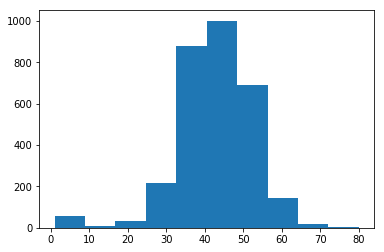

In [50]:
perp_fox = []

for a in fox_content:
    try:
        perp_fox.append(fox_model_3.perplexity(a))
    except:
        pass
    
plt.hist(perp_fox);

# plt.hist([fox_model_4.perplexity(a) for a in fox_content])

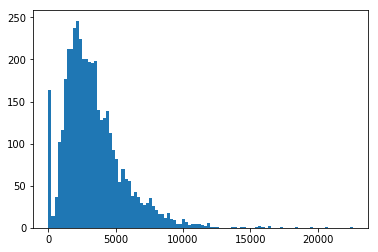

In [47]:
perp_fox = []

for a in cnn_content:
    try:
        perp_fox.append(fox_model_3.perplexity(a))
    except:
        pass
    
plt.hist(perp_fox, bins=100);

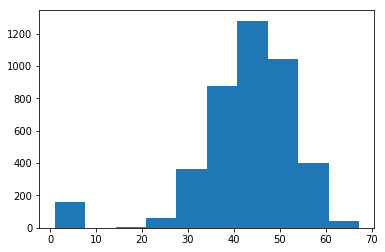

In [51]:
perp_cnn = []

for a in cnn_content:
    try:
        perp_cnn.append(cnn_model_3.perplexity(a))
    except:
        pass
    
plt.hist(perp_cnn);

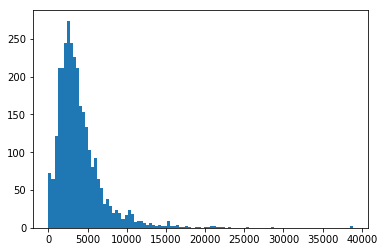

In [53]:
perp_cnn = []

for a in fox_content:
    try:
        perp_cnn.append(cnn_model_3.perplexity(a))
    except:
        pass
    
plt.hist(perp_cnn, bins=100);

The result is as expected. Fox articles and CNN articles have higher perplexity for CNN and Fox Language models respectively.

## Classification Models

Now, finally, we move to see whether we can classify whether articles are Left-wing or Right-wing. We have an array of ML algorithms at our hand and we have done a lot of exploratory analysis to help us with the answer. We will use the standard TFIDF models to convert these articles into a feature matrix and then use the CNN and Fox News labels to conduct a learning experiment, and compare against Logistic Regression, Linear SVC, Multinomial Naive Bayes and Random Forest. We expect random forest to perform best. We use cross-validation to test models, and then tune the best model and display results.

In [54]:
cnn_trump.rename(columns={"CNN_URL":"URL"}, inplace=True)
cnn_trump["Source"] = "CNN"
fox_trump.rename(columns={"Fox_URL":"URL"}, inplace=True)
fox_trump["Source"] = "Fox"
all_trump = fox_trump.append(cnn_trump).reset_index().drop("index", axis=1)

In [ ]:
all_trump["title_processed"] = all_trump["title_processed"].apply(lambda x: " ".join(x))
all_trump["text_processed"] = all_trump["text_processed"].apply(lambda x: " ".join(x))
all_trump.head()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [27]:
all_trump['Label'] = all_trump['Source'].apply(lambda x: 1 if x == 'CNN' else 0)
label_to_source = {0: 'Fox',
                  1: 'CNN'}
source_to_label = {'Fox': 0,
                  'CNN': 1}

In [21]:
tfidf = TfidfVectorizer(min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(all_trump.title_processed).toarray()
labels = all_trump.Source
features.shape

(7279, 2644)

In [30]:
from sklearn.feature_selection import chi2
import numpy as np

N = 5
for source, label in sorted(source_to_label.items()):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(source))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'CNN':
  . Most correlated unigrams:
. giuliani
. gives
. giving
. gm
. zinke
  . Most correlated bigrams:
. gop senator
. government shutdown
. george bush
. george papadopoulos
. giuliani says
# 'Fox':
  . Most correlated unigrams:
. giuliani
. gives
. giving
. gm
. zinke
  . Most correlated bigrams:
. gop senator
. government shutdown
. george bush
. george papadopoulos
. giuliani says


First, we check which are the most correlated words in the two articles. The most correlated unigrams and bigrams are listed above. They include Giuliani (President Trump's personal lawyer), GOP Senator, Government Shutdown, George Papadopoulos and Giuliani says.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(all_trump['title_processed'], all_trump['Source'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

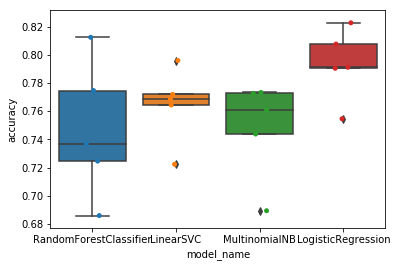

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df)#, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

This is a most interesting result. It is very strange that Logistic Regression performs the best. Random Forest has a spread of accuracies bbut doesn't come close to Logistic Regression, which is at the top.

In [35]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.764660
LogisticRegression        0.793373
MultinomialNB             0.748034
RandomForestClassifier    0.602966
Name: accuracy, dtype: float64

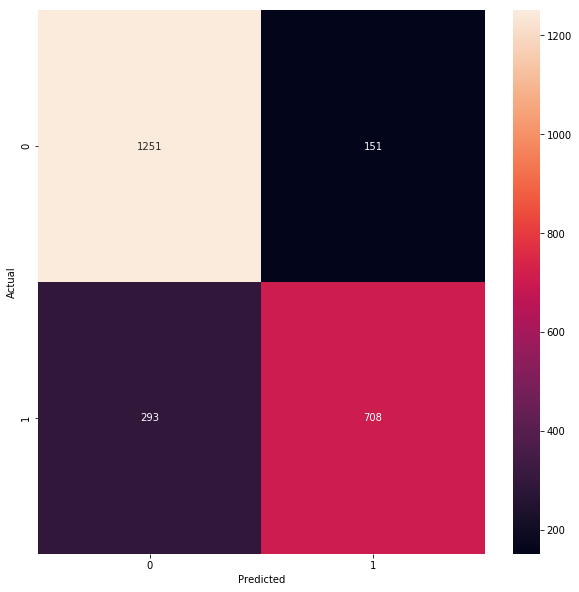

In [43]:
model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all_trump.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')#,
#             xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The errors are more inclined towards predicting CNN as Fox News, rather than the other way round, by almost a factor of 2.

## Conclusions and Future Work

This project has been trying to gauge the technical language used by CNN and Fox News and tried to see what interesting analysis could be conducted, and if there was enough interesting mutual information to classify the article as Right-wing and Left-wing. We got 82% accuracy which is pretty good. This is a newly conceived dataset, so there are no pre-existing benchmarks to guide us, but over 80% is a decent start.

The project has run out of money, so we have to stop here, but with more money, more interpretable models could be used, and packages like ELI5 and skater can help us with feature importance etc.

Thank you! Please request the datasets from yashkumar1803@gmail.com.

-Yash Kumar